In [1]:
import numpy as np
import qiskit as qis

from numpy.random import default_rng

from qiskit.exceptions import QiskitError
from qiskit.quantum_info.operators.random import * 
from qiskit_aer.backends import AerSimulator
from qiskit.quantum_info import *
from qiskit.primitives import Sampler

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector

from qiskit.quantum_info import Pauli
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error, amplitude_damping_error)
#from qiskit.extensions import Initialize

from matplotlib.pyplot import figure



%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Botond\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Creating a class where we can call functions

Qubit Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'anc1': 4, 'anc2': 5, 'anc3': 6, 'anc4': 7}


C:\Users\Botond\AppData\Local\Temp\ipykernel_9804\3179144388.py:149: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Show the figure with qubit labels


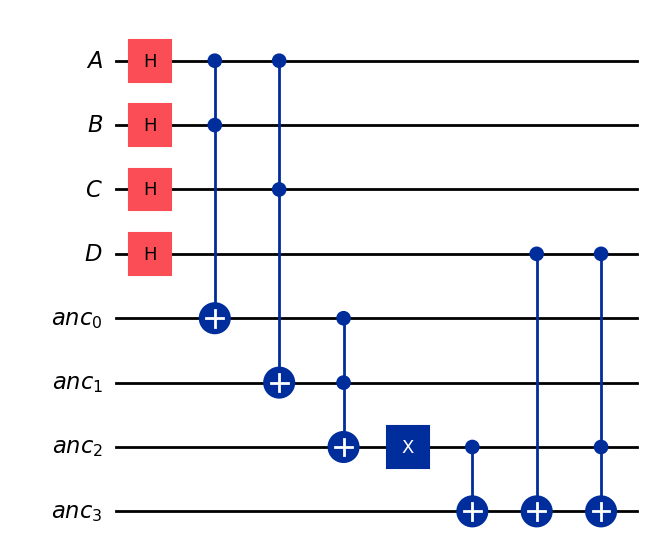

In [2]:
from qiskit import QuantumCircuit, QuantumRegister

def extract_variables(expr):
    """Recursively extract unique variables from the logical expression.
    Checks if expr is a list and if it is it skips the first element (the logical connective)
    and adds the variables to the set (which is good because automatically handles the duplicates)"""
    variables = set()
    if isinstance(expr, list):
        for sub_expr in expr[1:]:  # Skip the connective (e.g., "and", "or")
            variables.update(extract_variables(sub_expr))
    elif isinstance(expr, str):  # It's a variable (e.g., "A", "B")
        variables.add(expr)
    return variables

def count_connectives(expr):
    """Recursively count the number of logical connectives.
    Checks if expr is a list and if it is it adds +1 to count"""
    count = 0
    if isinstance(expr, list):
        count += 1  # Count this connective
        for sub_expr in expr[1:]:
            count += count_connectives(sub_expr)
    return count

def resolve_expression(expr, circuit, qubits_map, ancilla_start, ancilla_counter):
    """Recursively resolve nested logical expressions and translate them to Q gates.
    Returns the qubit index storing the result of this sub-expression."""
    if isinstance(expr, str):  # It's a variable
        return qubits_map[expr]
    
    if isinstance(expr, list) and len(expr) > 1:
        """If the expr is a list it selects the first argument as the gate (logical connective) and the others as the qubits"""
        gate = expr[0]  # The logical connective (e.g., "and", "or", etc.)
        args = expr[1:]

        # Resolve arguments recursively
        """By rerunning it we get the arguments as they form a sting when checking with the isinstance and collects them"""
        resolved_args = [resolve_expression(arg, circuit, qubits_map, ancilla_start, ancilla_counter) for arg in args]

        # Allocate ancilla for this operation
        """For every quantum gate set we have an ancilla where we store the final output
        the position of this ancilla must shift/change so we do not get piled up"""
        target = ancilla_start + ancilla_counter[0]
        ancilla_counter[0] += 1  # Increment the counter

        # Apply Quantum Gates for Logical Connectives
        """Then it applies the quantum gate representing the logical connective"""
        if gate == "not" and len(resolved_args) == 1:
            circuit.x(resolved_args[0])  
            circuit.cx(resolved_args[0], target)  

        elif gate == "and" and len(resolved_args) == 2:
            q1, q2 = resolved_args
            circuit.ccx(q1, q2, target)  

        elif gate == "or" and len(resolved_args) == 2:
            q1, q2 = resolved_args
            circuit.cx(q1, target)  
            circuit.cx(q2, target)  
            circuit.ccx(q1, q2, target)  

        elif gate == "xor" and len(resolved_args) == 2:
            q1, q2 = resolved_args
            circuit.cx(q1, target)  
            circuit.cx(q2, target)  

        elif gate == "implication" and len(resolved_args) == 2:
            q1, q2 = resolved_args
            circuit.x(q1)    
            circuit.cx(q1, target)  
            circuit.cx(q2, target)  
            circuit.ccx(q1, q2, target)  

        elif gate == "bijection" and len(resolved_args) == 2:
            q1, q2 = resolved_args
            circuit.cx(q1, target)  
            circuit.cx(q2, target)  
            circuit.x(target)  

        else:
            raise ValueError(f"Unknown or improperly formatted gate: {gate}")
        
        return target

def logical_to_quantum(expression):
    """Automatically maps logical expressions to quantum circuits with dynamic qubit allocation."""
    # Extract variables and count connectives
    variables = extract_variables(expression)
    num_ancilla = count_connectives(expression)

    # Dynamic Qubit Mapping
    var_list = sorted(list(variables))  #sort the variables
    qubits_map = {var: idx for idx, var in enumerate(var_list)} #get the qubits from the no. of variables
    ancilla_start = len(qubits_map) #have the ancillas properly sorted
    ancilla_map = {f"anc{i+1}": ancilla_start + i for i in range(num_ancilla)}    #get the qubits from the no. of ancillas
    qubits_map.update(ancilla_map)  #update the no. of qubits

    # Create Quantum Register with Named Qubits

    circuit = QuantumCircuit()
    for name in sorted(variables):
        qreg = QuantumRegister(1, name=name)
        circuit.add_register(qreg)
        
    anc_reg = QuantumRegister(num_ancilla, name = "anc")
    #out_reg = ClassicalRegister(1, name = "OUT")
    circuit.add_register(anc_reg) #, out_reg)
        
    #qreg = QuantumRegister(len(qubits_map), name="q")
    #creg = ClassicalRegister(1, name="OUT")
    #circuit = QuantumCircuit(qreg, creg) #generate the quantum registers and circuit based on the no. of variables + ancillas
    
    
    #Add Hadamard Gates to Basis Qubits to create superposition
    basis_qubits = set(range(len(variables)))  # Indices of the logical variables
    for q in basis_qubits:
        circuit.h(q)  # Apply Hadamard to each basis qubit

    # Resolve the expression
    ancilla_counter = [0]  # Use a list to keep the counter mutable
    final_result = resolve_expression(expression, circuit, qubits_map, ancilla_start, ancilla_counter)
    #print(f"Final result stored in qubit: {final_result}")  #show where do we store the final qubit
    
    return circuit, qubits_map

def draw_with_labels(circuit, qubits_map):
    """Draws the circuit with labels."""
    fig = circuit.draw('mpl')
    ax = fig.get_axes()[0]

    # Annotate qubits with variable names
    for var, qubit_idx in qubits_map.items():
        ax.text(0, qubit_idx, var, horizontalalignment='center', verticalalignment='center', color='red', fontsize=12)

    return fig

# Example Logical Expression
anything = ["xor", ["xor", ["xor", "A", "B"], ["xor", "C", "D"]], ["xor", "E", "F"]]
ex1 = ["or", ["or", "A", "B"], ["not", "C"]]
ex2 = ["implication", ["xor", ["and", "A", "B"], ["and", "C", "D"]], ["and", "E", "F"]]
ex3 = ["implication",   ["and", ["and", "A", "B"], ["and", "A", "C"]], "D"]

# Generate Quantum Circuit with Dynamic Qubit Allocation
qc, qubits_map = logical_to_quantum(ex3)
print("Qubit Mapping:", qubits_map)

# Draw the circuit with labels
fig = draw_with_labels(qc, qubits_map)
fig.show()  # Show the figure with qubit labels

qc.draw('mpl')  # Draw the circuit


In [3]:
def oracle1(input_circ):
    len = input_circ.num_qubits
    b1 = QuantumCircuit(len)
    b1.z(len - 1)

    return b1

def oracle0(input_circ):
    len = input_circ.num_qubits
    b1 = QuantumCircuit(len)
    b1.x(len - 1)
    b1.z(len - 1)
    b1.x(len - 1)
    
    return b1

def diffusion(input_circ):
    len = input_circ.num_qubits
    b1 = QuantumCircuit(len)
    b2 = b1.compose(input_circ.inverse())

    for qubit in range(len ):
        b2.x(qubit)

    b2.h(len - 1)
    b2.mcx(list(range(0, len - 1)), len - 1)
    b2.h(len - 1)

    for qubit in range(len ):
        b2.x(qubit)

    diffusion = b2.compose(input_circ)

    return diffusion

def apply_sunscreen(circuit, oracle, amplifier, rounds):
    for _ in range(rounds):
        circuit = circuit.compose(oracle).compose(amplifier)

    return circuit



the oracle is:


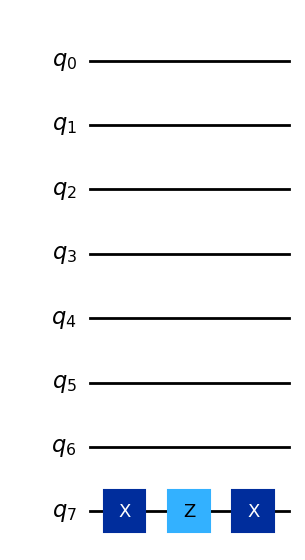

In [4]:
orac = oracle0(qc)
diff = diffusion(qc)

print("the oracle is:")

orac.draw('mpl')  # Draw the oracle

the diffusion operator is:


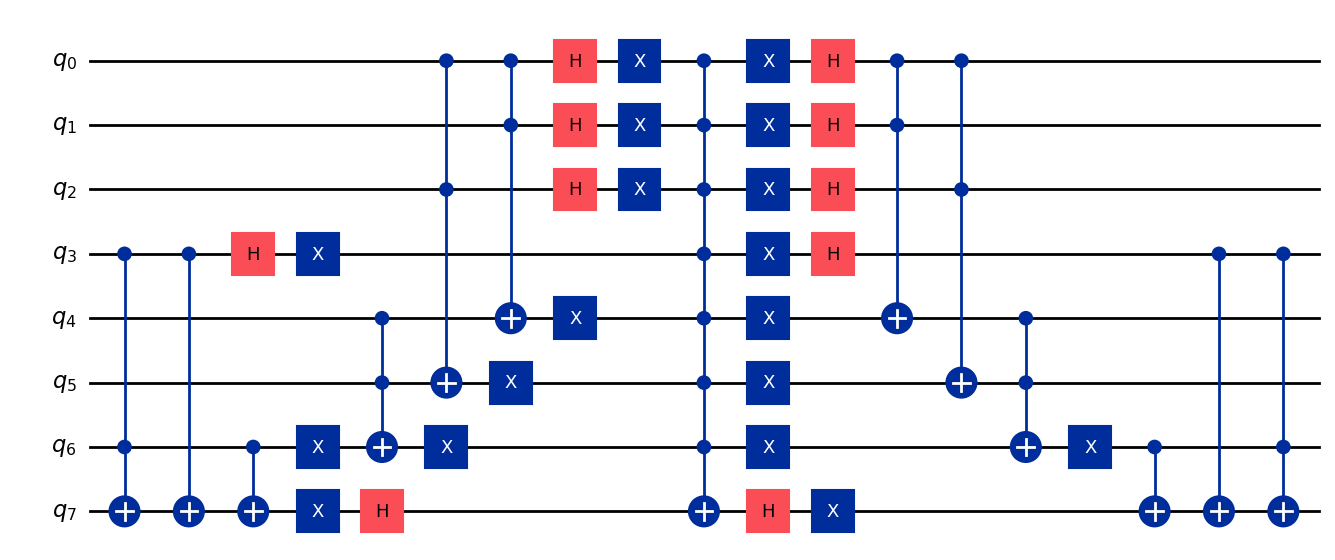

In [5]:
print("the diffusion operator is:")

diff.draw('mpl')  # Draw the oracle

In [6]:
amplified_qc1 = apply_sunscreen(qc, orac, diff, 1) # Apply
amplified_qc2 = apply_sunscreen(qc, orac, diff, 2)
amplified_qc3 = apply_sunscreen(qc, orac, diff, 3)
amplified_qc4 = apply_sunscreen(qc, orac, diff, 4)

In [7]:
len(qubits_map)

8

In [8]:
prep_circ_out = qc.copy()
prep_circ_out.add_register(ClassicalRegister(1))

prep_circ_out.measure(len(qubits_map)-1, 0)

results_prep_out = Sampler().run(prep_circ_out).result()
prep_out = results_prep_out.quasi_dists[0].binary_probabilities()

prep_circ_out_4 = qc.copy()
prep_circ_out_4.add_register(ClassicalRegister(4))

prep_circ_out_4.measure([0,1,2,3], [0,1,2,3])

results_prep_out_4 = Sampler().run(prep_circ_out_4).result()
prep_out_4 = results_prep_out_4.quasi_dists[0].binary_probabilities()

C:\Users\Botond\AppData\Local\Temp\ipykernel_9804\3965358025.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  results_prep_out = Sampler().run(prep_circ_out).result()
C:\Users\Botond\AppData\Local\Temp\ipykernel_9804\3965358025.py:14: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  results_prep_out_4 = Sampler().run(prep_circ_out_4).result()


In [9]:
amplfied_circ_out1 = amplified_qc1.copy()
amplfied_circ_out1.add_register(ClassicalRegister(1))

amplfied_circ_out1.measure(len(qubits_map)-1, 0)

results_amplfied_circ_out1 = Sampler().run(amplfied_circ_out1).result()
amp_out1 = results_amplfied_circ_out1.quasi_dists[0].binary_probabilities()

#-----------------------------------------------------------------------


amplfied_circ_out2 = amplified_qc2.copy()
amplfied_circ_out2.add_register(ClassicalRegister(1))

amplfied_circ_out2.measure(len(qubits_map)-1, 0)

results_amplfied_circ_out2 = Sampler().run(amplfied_circ_out2).result()
amp_out2 = results_amplfied_circ_out2.quasi_dists[0].binary_probabilities()

#-----------------------------------------------------------------------


amplfied_circ_out3 = amplified_qc3.copy()
amplfied_circ_out3.add_register(ClassicalRegister(1))

amplfied_circ_out3.measure(len(qubits_map)-1, 0)

results_amplfied_circ_out3 = Sampler().run(amplfied_circ_out3).result()
amp_out3 = results_amplfied_circ_out3.quasi_dists[0].binary_probabilities()

#-----------------------------------------------------------------------


amplfied_circ_out4 = amplified_qc4.copy()
amplfied_circ_out4.add_register(ClassicalRegister(1))

amplfied_circ_out4.measure(len(qubits_map)-1, 0)

results_amplfied_circ_out4 = Sampler().run(amplfied_circ_out4).result()
amp_out4 = results_amplfied_circ_out4.quasi_dists[0].binary_probabilities()

C:\Users\Botond\AppData\Local\Temp\ipykernel_9804\102223234.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  results_amplfied_circ_out1 = Sampler().run(amplfied_circ_out1).result()
C:\Users\Botond\AppData\Local\Temp\ipykernel_9804\102223234.py:17: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  results_amplfied_circ_out2 = Sampler().run(amplfied_circ_out2).result()
C:\Users\Botond\AppData\Local

In [10]:
amplfied_circ_out1_4 = amplified_qc1.copy()
amplfied_circ_out1_4.add_register(ClassicalRegister(4))

amplfied_circ_out1_4.measure([0,1,2,3], [0,1,2,3])

results_amplfied_circ_out1_4 = Sampler().run(amplfied_circ_out1_4).result()
amp_out1_4 = results_amplfied_circ_out1_4.quasi_dists[0].binary_probabilities()

#-----------------------------------------------------------------------

amplfied_circ_out2_4 = amplified_qc2.copy()
amplfied_circ_out2_4.add_register(ClassicalRegister(4))

amplfied_circ_out2_4.measure([0,1,2,3], [0,1,2,3])

results_amplfied_circ_out2_4 = Sampler().run(amplfied_circ_out2_4).result()
amp_out2_4 = results_amplfied_circ_out2_4.quasi_dists[0].binary_probabilities()

#-----------------------------------------------------------------------

amplfied_circ_out3_4 = amplified_qc3.copy()
amplfied_circ_out3_4.add_register(ClassicalRegister(4))

amplfied_circ_out3_4.measure([0,1,2,3], [0,1,2,3])

results_amplfied_circ_out3_4 = Sampler().run(amplfied_circ_out3_4).result()
amp_out3_4 = results_amplfied_circ_out3_4.quasi_dists[0].binary_probabilities()

#-----------------------------------------------------------------------

amplfied_circ_out4_4 = amplified_qc4.copy()
amplfied_circ_out4_4.add_register(ClassicalRegister(4))

amplfied_circ_out4_4.measure([0,1,2,3], [0,1,2,3])

results_amplfied_circ_out4_4 = Sampler().run(amplfied_circ_out4_4).result()
amp_out4_4 = results_amplfied_circ_out4_4.quasi_dists[0].binary_probabilities()


C:\Users\Botond\AppData\Local\Temp\ipykernel_9804\225021930.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  results_amplfied_circ_out1_4 = Sampler().run(amplfied_circ_out1_4).result()
C:\Users\Botond\AppData\Local\Temp\ipykernel_9804\225021930.py:16: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  results_amplfied_circ_out2_4 = Sampler().run(amplfied_circ_out2_4).result()
C:\Users\Botond\AppDa

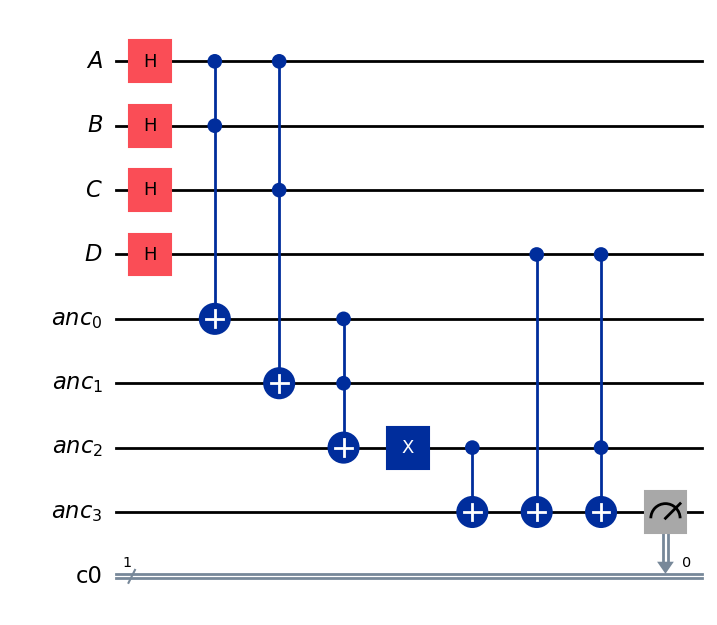

In [11]:
prep_circ_out.draw('mpl') # Draw the basic circ

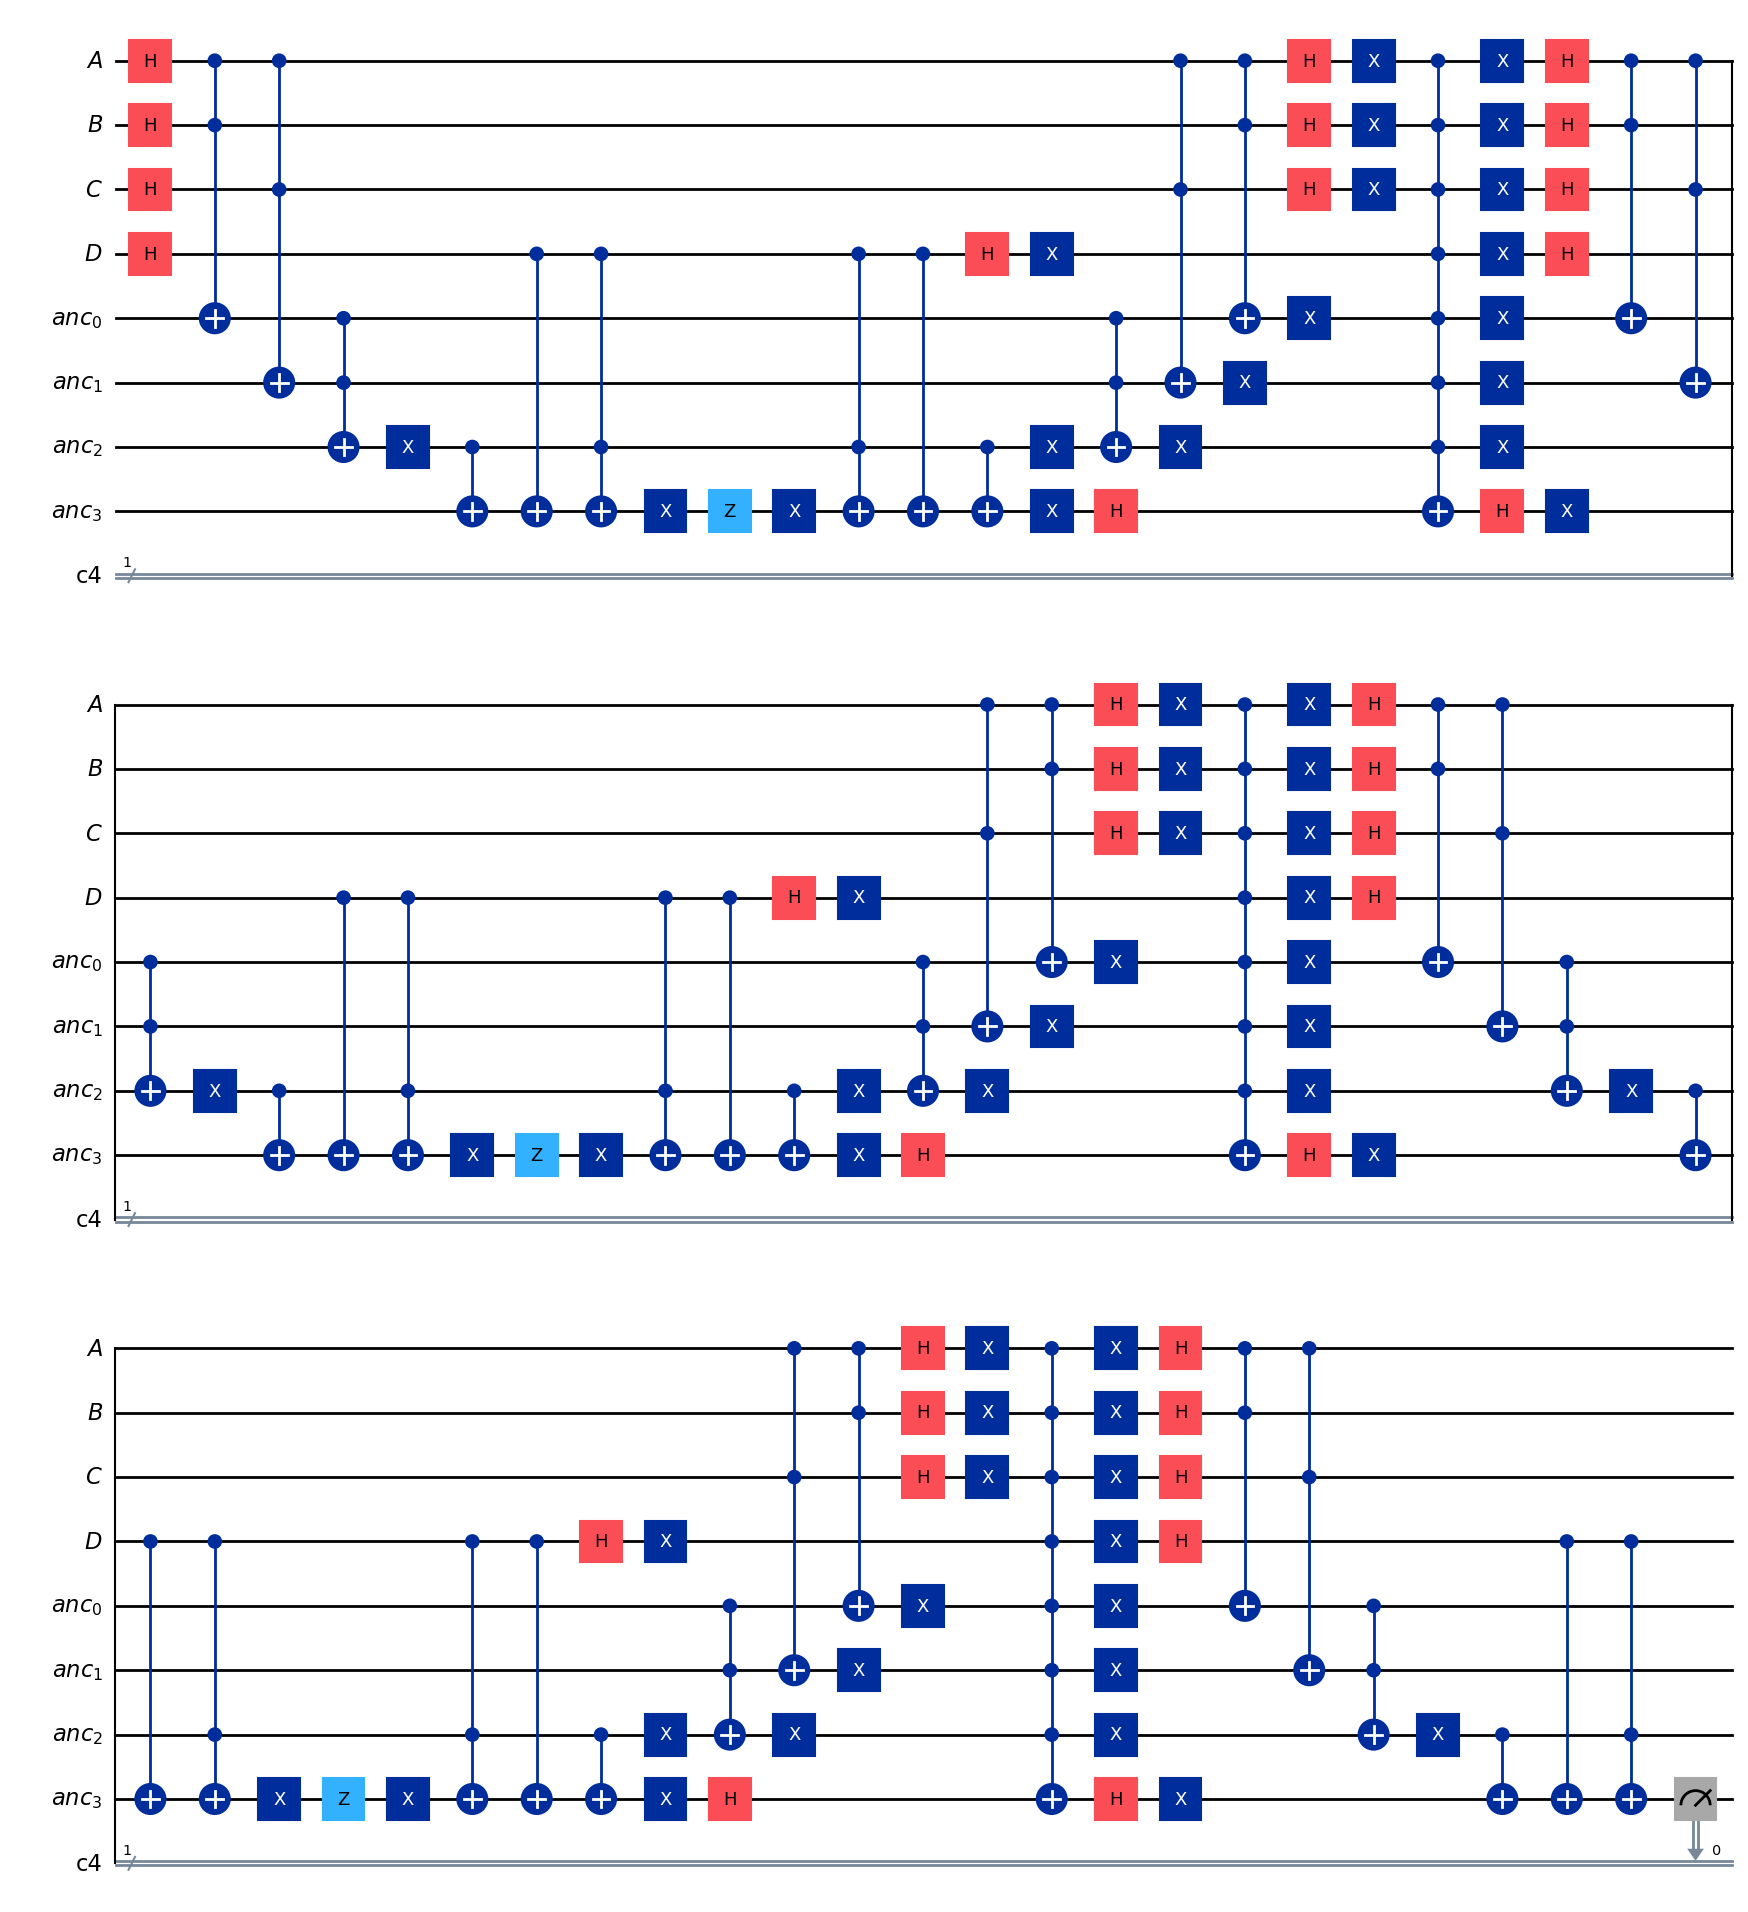

In [12]:
amplfied_circ_out3.draw('mpl') # Draw the amplified circ

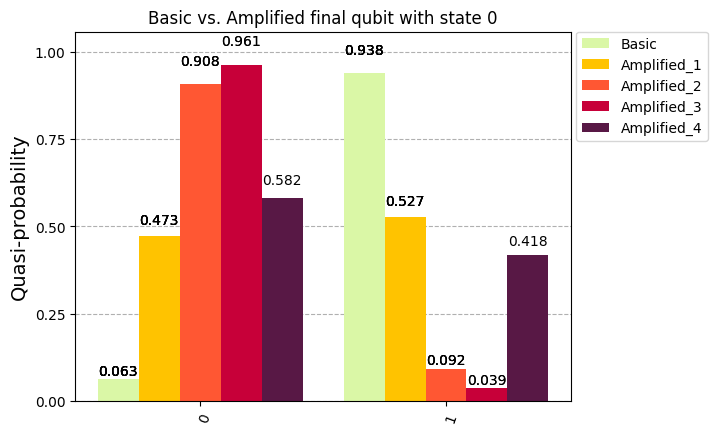

In [13]:
plot_histogram([prep_out, amp_out1, amp_out2, amp_out3, amp_out4], legend=["Basic", "Amplified_1", "Amplified_2", "Amplified_3", "Amplified_4"], color=['#DAF7A6', '#FFC300', '#FF5733', '#C70039', '#581845'],
                title="Basic vs. Amplified final qubit with state 0")

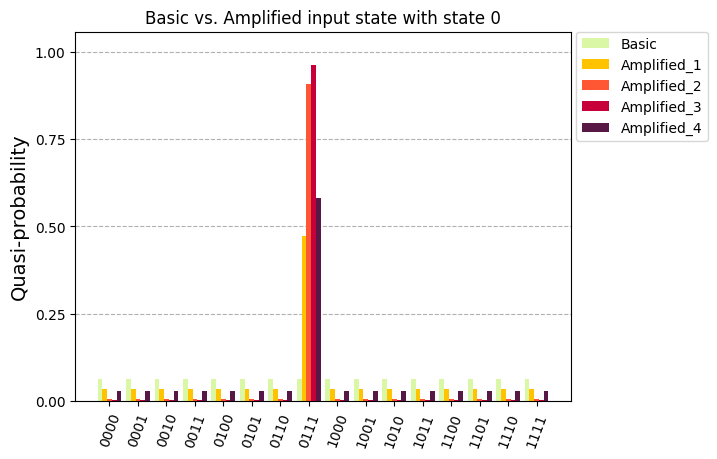

In [14]:
plot_histogram([prep_out_4, amp_out1_4, amp_out2_4, amp_out3_4, amp_out4_4], legend=["Basic", "Amplified_1", "Amplified_2", "Amplified_3", "Amplified_4"], color=['#DAF7A6', '#FFC300', '#FF5733', '#C70039', '#581845'],
                title="Basic vs. Amplified input state with state 0", bar_labels = 0)

In [15]:
angles = [arcsin(sqrt(prep_out['0'])), arcsin(sqrt(amp_out1['0'])), arcsin(sqrt(amp_out2['0'])), arcsin(sqrt(amp_out3['0'])), arcsin(sqrt(amp_out4['0']))]

In [16]:
angles

[0.25268025514207865,
 0.7580407654262306,
 1.2634012757103572,
 1.3728308675951602,
 0.8674703573110587]

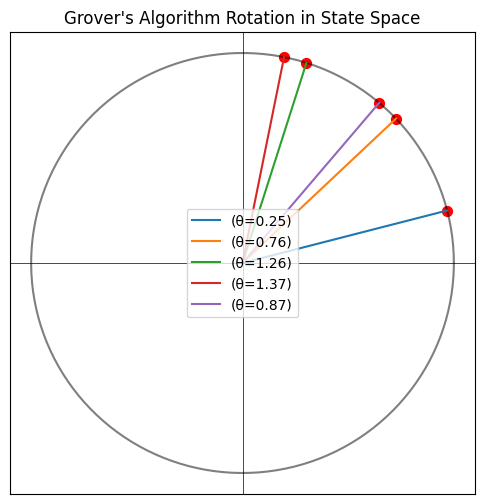

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define circle
theta = np.linspace(0, 2 * np.pi, 300)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

# Define angles for Grover rotations
num_steps = 5  # Number of Grover iterations to visualize
theta_0 = np.arcsin(np.sqrt(1/8))  # Example initial theta (M/N = 1/8)
theta_vals = [(2*k + 1) * theta_0 for k in range(num_steps)]  # Rotation steps

# Plot circle
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(circle_x, circle_y, 'Black', alpha=0.5)  # Unit circle

for theta_k in angles:
    x = np.cos(theta_k)  # Mapping angle to correct quadrant
    y = np.sin(theta_k)
    ax.plot([0, x], [0, y], label=f"(θ={theta_k:.2f})")
    ax.scatter(x, y, color='red', s=50)

# Axes and labels
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Grover's Algorithm Rotation in State Space")
ax.legend()

plt.show()


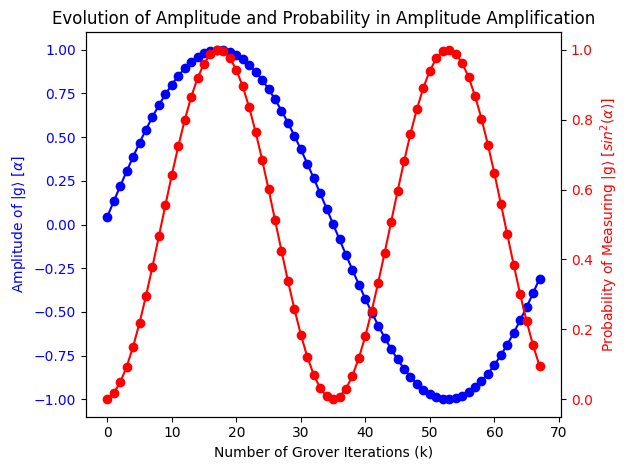

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math

N = 512  # Total states
M = 1  # Solution states
p = M/N # Probability of finding a good state

# Number of Grover iterations
k_values = np.arange(0, 4*np.floor(math.pi /4 * np.sqrt(1/p)))  # From 0 to 4 times the needed rotations 

# Initial theta (assume M/N = 1/8 for an example)
theta_0 = np.arcsin(np.sqrt(p))

# Compute theta after k iterations
theta_k = (2 * k_values + 1) * theta_0

# Compute amplitudes and probabilities
amplitude_w = np.sin(theta_k)  # Amplitude of solution state |w⟩
probability_w = amplitude_w**2  # Probability of measuring |w⟩
probability_wb = 1 - probability_w
# Plot the rotation as a function of iterations
fig, ax1 = plt.subplots()

ax1.set_xlabel("Number of Grover Iterations (k)")
ax1.set_ylabel("Amplitude of |g⟩ [" + r"$\alpha$" + "]", color="blue")
ax1.plot(k_values, amplitude_w, "bo-", label="Amplitude (sinθ)")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Probability of Measuring |g⟩ [" + r"${sin^2(\alpha)}$" + "]", color="red")
ax2.plot(k_values, probability_w, "ro-", label="Probability (sin²θ)")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Evolution of Amplitude and Probability in Amplitude Amplification")
fig.tight_layout()
plt.show()



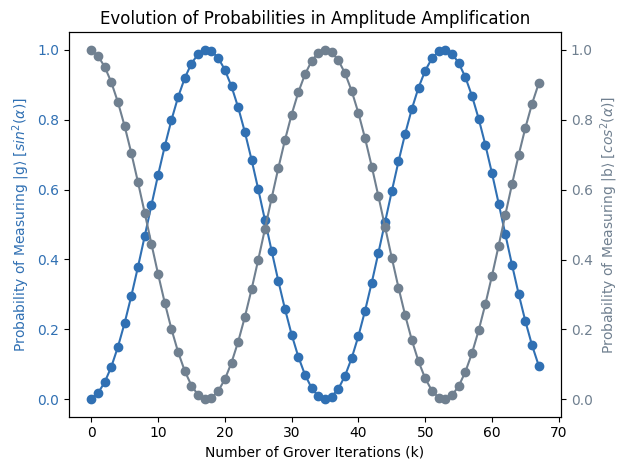

In [83]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Number of Grover Iterations (k)")
ax1.set_ylabel("Probability of Measuring |g⟩ [" + r"${sin^2(\alpha)}$" + "]", color="#3070B3")
ax1.plot(k_values, probability_w, color= "#3070B3", linestyle="-", marker="o", label="Amplitude (sinθ)")
ax1.tick_params(axis="y", labelcolor="#3070B3")

ax2 = ax1.twinx()
ax2.set_ylabel("Probability of Measuring |b⟩ [" + r"${cos^2(\alpha)}$" + "]", color="#708090")
ax2.plot(k_values, probability_wb, color='#708090', linestyle="-", marker="o", label="Probability (sin²θ)")
ax2.tick_params(axis="y", labelcolor="#708090")

plt.title("Evolution of Probabilities in Amplitude Amplification")
fig.tight_layout()
plt.show()

The rotations needed for maximum amplification:  17.0
The rotations presented in the picture:  68.0
The starting probability:p_0 = 1 / 512


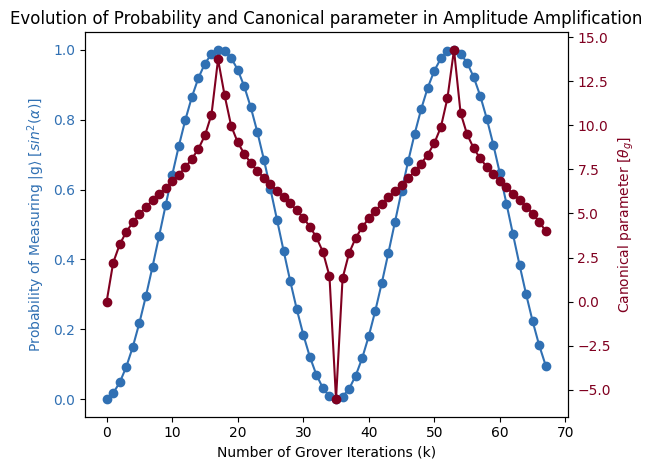

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import math

N = 512  # Total states
M = 1  # Solution states
p0 = M/N # Probability of finding a good state
p0b = 1 - M/N
k = np.floor(math.pi / 4 * np.sqrt(1/p0))

# Number of Grover iterations
k_values = np.arange(0, 4*np.floor(math.pi /4 * np.sqrt(1/p0)))  # From 0 to 4 times the needed rotations 

# Initial alpha (assume M/N = 1/8 for an example)
alpha_0 = np.arcsin(np.sqrt(p0))

# Compute alpha after k iterations
alpha_k = (2 * k_values + 1) * alpha_0

# Compute amplitudes and probabilities
amplitude_w = np.sin(alpha_k)  # Amplitude of solution state |w⟩
probability_w = amplitude_w**2  # Probability of measuring |w⟩
probability_wb = 1 - probability_w
# Initial theta value -- canonical parameter for the exponential family
theta_0 = math.log(((1-p0)*p0)/((1-p0)*p0))

# Compute theta after k iterations from the probabilities
theta_k = []
theta_kb = []
for i in range(0, len(k_values)):
    theta_k.append(math.log(((1-p0)*probability_w[i])/((1-probability_w[i])*p0)))
    theta_kb.append(math.log(((1-p0b)*probability_wb[i])/((1-probability_wb[i])*p0b)))
# Plot the rotation as a function of iterations
fig, ax1 = plt.subplots()

ax1.set_xlabel("Number of Grover Iterations (k)")
ax1.set_ylabel("Probability of Measuring |g⟩ [" + r"${sin^2(\alpha)}$" + "]", color="#3070B3")
ax1.plot(k_values, probability_w, color="#3070B3", linestyle="-", marker="o", label="Probability (sin²θ)")
ax1.tick_params(axis="y", labelcolor="#3070B3")

ax2 = ax1.twinx()
ax2.set_ylabel("Canonical parameter [" + r"${\theta_g}$" + "]", color="#800020")
ax2.plot(k_values, theta_k,color="#800020" , linestyle="-", marker="o", label="Canonical parameter [" + r"${\theta}$" + "]")
ax2.tick_params(axis="y", labelcolor="#800020")

print("The rotations needed for maximum amplification: ", k)
print("The rotations presented in the picture: ", 4*k)
print("The starting probability:" + "p_0" + " =", M, "/", N)

plt.title("Evolution of Probability and Canonical parameter in Amplitude Amplification")
fig.tight_layout()
plt.show()



The rotations needed for maximum amplification:  17.0
The rotations presented in the picture:  68.0
The starting probability:p_0 = 1 / 512


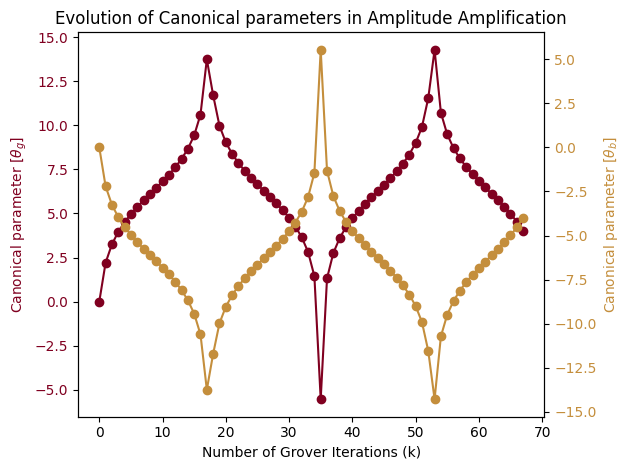

In [84]:
fig, ax1 = plt.subplots()

ax1.set_xlabel("Number of Grover Iterations (k)")
ax1.set_ylabel("Canonical parameter [" + r"${\theta_g}$" + "]", color="#800020")
ax1.plot(k_values, theta_k, color="#800020", linestyle="-", marker="o", label="Canonical parameter [" + r"${\theta}$" + "]")
ax1.tick_params(axis="y", labelcolor="#800020")

ax2 = ax1.twinx()
ax2.set_ylabel("Canonical parameter [" + r"${\theta_b}$" + "]", color="#C48E3C")
ax2.plot(k_values, theta_kb,color="#C48E3C", linestyle="-", marker="o", label="Canonical parameter [" + r"${\theta}$" + "]")
ax2.tick_params(axis="y", labelcolor="#C48E3C")

print("The rotations needed for maximum amplification: ", k)
print("The rotations presented in the picture: ", 4*k)
print("The starting probability:" + "p_0" + " =", M, "/", N)

plt.title("Evolution of Canonical parameters in Amplitude Amplification")
fig.tight_layout()
plt.show()


The rotations needed for maximum amplification:  17.0
The rotations presented in the picture:  68.0
The starting probability:p_0 = 1 / 512


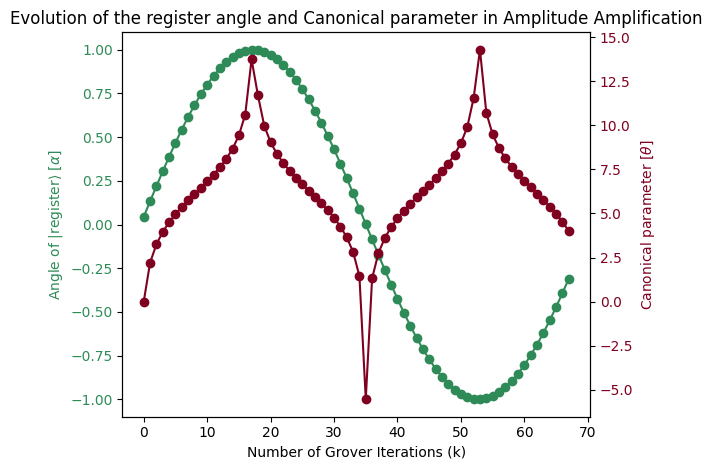

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import math

N = 512  # Total states
M = 1  # Solution states
p0 = M/N # Probability of finding a good state
k = np.floor(math.pi / 4 * np.sqrt(1/p0))

# Number of Grover iterations
k_values = np.arange(0, 4*np.floor(math.pi /4 * np.sqrt(1/p0)))  # From 0 to 4 times the needed rotations 

# Initial alpha (assume M/N = 1/8 for an example)
alpha_0 = np.arcsin(np.sqrt(p0))

# Compute alpha after k iterations
alpha_k = (2 * k_values + 1) * alpha_0

# Compute amplitudes and probabilities
amplitude_w = np.sin(alpha_k)  # Amplitude of solution state |w⟩
probability_w = amplitude_w**2  # Probability of measuring |w⟩

# Initial theta value -- canonical parameter for the exponential family
theta_0 = math.log(((1-p0)*p0)/((1-p0)*p0))

# Compute theta after k iterations from the probabilities
theta_k = []
for i in range(0, len(k_values)):
    theta_k.append(math.log(((1-p0)*probability_w[i])/((1-probability_w[i])*p0)))

# Plot the rotation as a function of iterations
fig, ax1 = plt.subplots()

ax1.set_xlabel("Number of Grover Iterations (k)")
ax1.set_ylabel("Angle of |register⟩ [" + r"$\alpha$" + "]", color="#2E8B57")
ax1.plot(k_values, amplitude_w, color="#2E8B57", linestyle="-", marker="o", label="Amplitude (sinθ)")
ax1.tick_params(axis="y", labelcolor="#2E8B57")

ax2 = ax1.twinx()
ax2.set_ylabel("Canonical parameter [" + r"${\theta}$" + "]", color="#800020")
ax2.plot(k_values, theta_k, color="#800020", linestyle="-", marker="o", label="Canonical parameter [" + r"${\theta}$" + "]")
ax2.tick_params(axis="y", labelcolor="#800020")

print("The rotations needed for maximum amplification: ", k)
print("The rotations presented in the picture: ", 4*k)
print("The starting probability:" + "p_0" + " =", M, "/", N)

plt.title("Evolution of the register angle and Canonical parameter in Amplitude Amplification")
fig.tight_layout()
plt.show()



In [28]:
k_values

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67.])

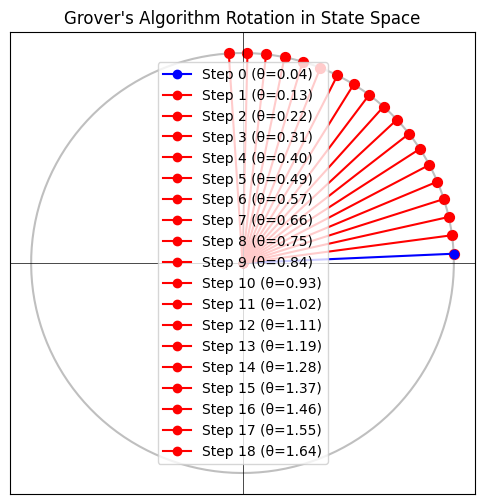

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define circle
theta = np.linspace(0, 2 * np.pi, 300)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

# Define angles for Grover rotations
num_steps = 2 + int(np.floor(math.pi /4 * np.sqrt(1/p)))  # Number of Grover iterations to visualize
theta_0 = np.arcsin(np.sqrt(p)) # Example initial theta (M/N = 1/8)
theta_vals = [(2*k + 1) * theta_0 for k in range(num_steps)]  # Rotation steps

# Plot circle
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(circle_x, circle_y, 'gray', alpha=0.5)  # Unit circle

# Plot initial state and rotated states
for i, theta_k in enumerate(theta_vals):
    x = np.cos(theta_k)  # Mapping angle to correct quadrant
    y = np.sin(theta_k)
    ax.plot([0, x], [0, y], 'bo-' if i == 0 else 'ro-', label=f"Step {i} (θ={theta_k:.2f})")
    ax.scatter(x, y, color='red', s=50)

# Axes and labels
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Grover's Algorithm Rotation in State Space")
ax.legend()

plt.show()


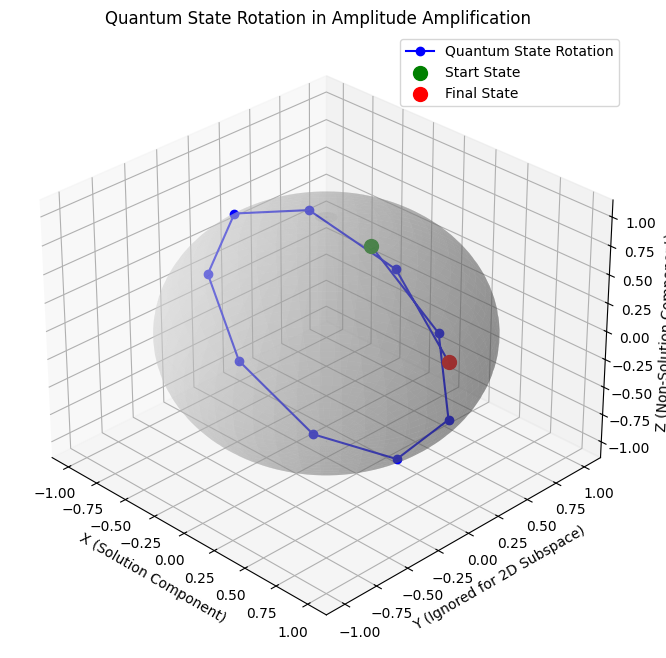

In [29]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D Bloch sphere plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Compute Bloch sphere coordinates (X, Y, Z) for the quantum state
X = np.sin(theta_k)  # Projection onto X-axis (solution amplitude)
Y = np.zeros_like(X)  # No movement in Y-direction (since we are in 2D subspace)
Z = np.cos(theta_k)  # Projection onto Z-axis (non-solution amplitude)

# Plot the Bloch sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 50)
X_sphere = np.outer(np.cos(u), np.sin(v))
Y_sphere = np.outer(np.sin(u), np.sin(v))
Z_sphere = np.outer(np.ones_like(u), np.cos(v))

ax.plot_surface(X_sphere, Y_sphere, Z_sphere, color="lightgray", alpha=0.35)  # Bloch sphere

# Plot rotation of quantum state
ax.plot(X, Y, Z, "bo-", label="Quantum State Rotation")
ax.scatter(X[0], Y[0], Z[0], color="green", s=100, label="Start State")  # Initial state
ax.scatter(X[-1], Y[-1], Z[-1], color="red", s=100, label="Final State")  # Final state

# Labels and view angle
ax.set_xlabel("X (Solution Component)")
ax.set_ylabel("Y (Ignored for 2D Subspace)")
ax.set_zlabel("Z (Non-Solution Component)")
ax.set_title("Quantum State Rotation in Amplitude Amplification")
ax.view_init(elev=30, azim=-45, )  # Adjust angle for better visualization
ax.legend()

plt.show()


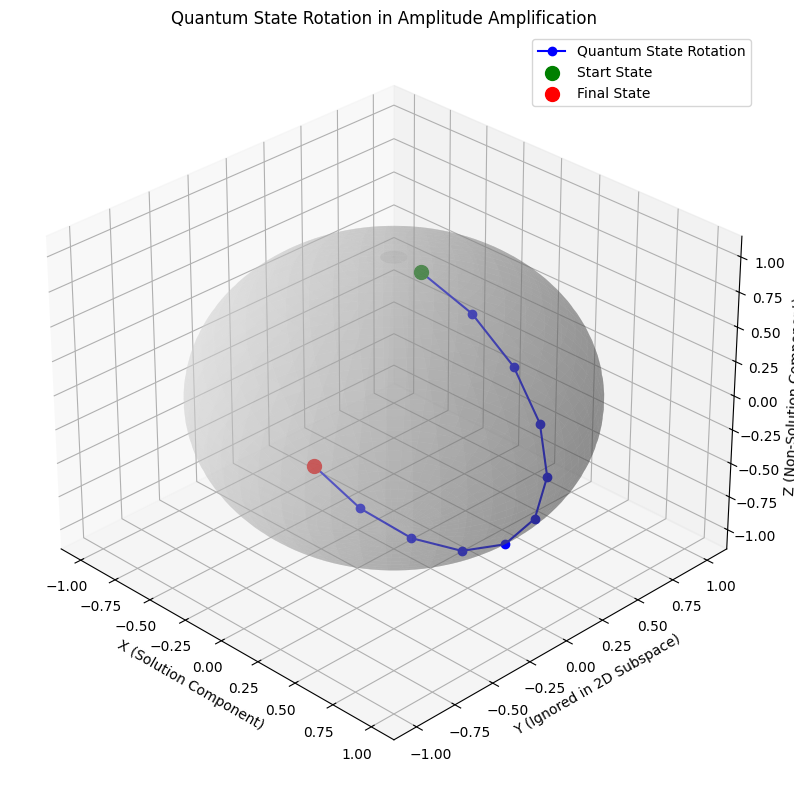

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define Grover iterations and initial angle
k_values = np.arange(0, 11)
theta_0 = np.arcsin(np.sqrt(1 / 32))  # Example: M/N = 1/8
theta_k = (2 * k_values + 1) * theta_0  # Rotation angles after each Grover iteration

# Compute Bloch coordinates
X = np.sin(theta_k)             # Projection onto X-axis (solution)
Y = np.zeros_like(X)            # No Y movement in 2D subspace
Z = np.cos(theta_k)             # Projection onto Z-axis (non-solution)

# Create a 3D Bloch sphere plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Generate Bloch sphere surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 50)
X_sphere = np.outer(np.cos(u), np.sin(v))
Y_sphere = np.outer(np.sin(u), np.sin(v))
Z_sphere = np.outer(np.ones_like(u), np.cos(v))

# Plot the Bloch sphere
ax.plot_surface(X_sphere, Y_sphere, Z_sphere, color="lightgray", alpha=0.35)

# Plot quantum state trajectory
ax.plot(X, Y, Z, "bo-", label="Quantum State Rotation")
ax.scatter(X[0], Y[0], Z[0], color="green", s=100, label="Start State")
ax.scatter(X[-1], Y[-1], Z[-1], color="red", s=100, label="Final State")

# Labels and appearance
ax.set_xlabel("X (Solution Component)")
ax.set_ylabel("Y (Ignored in 2D Subspace)")
ax.set_zlabel("Z (Non-Solution Component)")
ax.set_title("Quantum State Rotation in Amplitude Amplification")
ax.view_init(elev=30, azim=-45)
ax.legend()

plt.tight_layout()
plt.show()


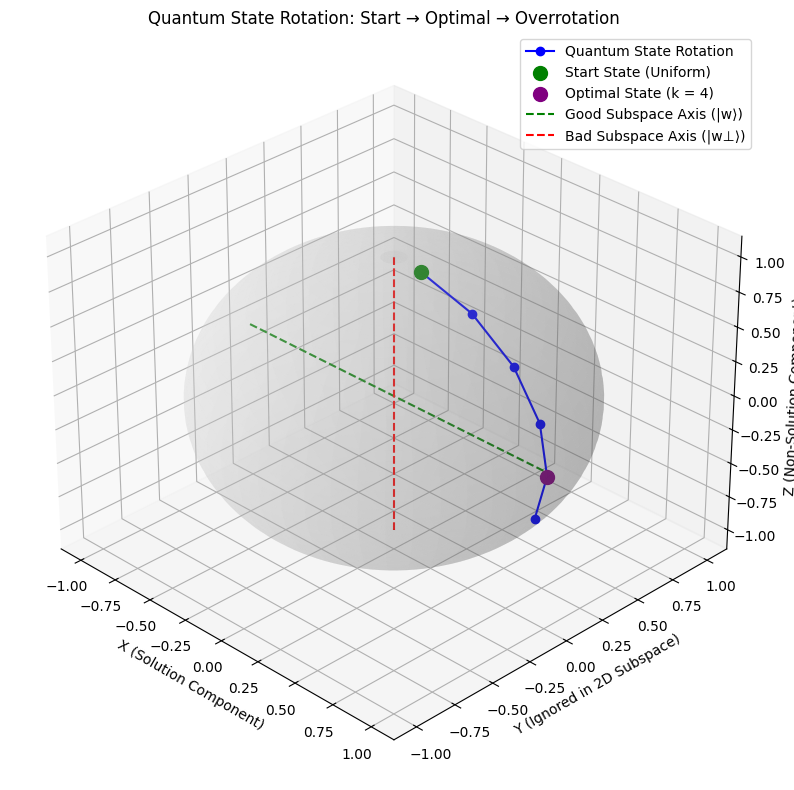

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

# Parameters
N = 32  # Total states
M = 1   # Solution states
p0 = M / N
k_opt = int(np.floor(np.pi / 4 * np.sqrt(1 / p0)))  # Optimal number of Grover iterations

# Define extended range of Grover iterations to show overrotation
k_values = np.arange(0, k_opt + 2)
theta_0 = np.arcsin(np.sqrt(p0))
theta_k = (2 * k_values + 1) * theta_0

# Compute Bloch coordinates
X = np.sin(theta_k)             # Projection onto X-axis (solution)
Y = np.zeros_like(X)            # Y-axis ignored in 2D Grover space
Z = np.cos(theta_k)             # Projection onto Z-axis (non-solution)

# Create 3D Bloch sphere
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot Bloch sphere surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 50)
X_sphere = np.outer(np.cos(u), np.sin(v))
Y_sphere = np.outer(np.sin(u), np.sin(v))
Z_sphere = np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(X_sphere, Y_sphere, Z_sphere, color="lightgray", alpha=0.2)

# Plot the Grover rotation path
ax.plot(X, Y, Z, "bo-", label="Quantum State Rotation")
ax.scatter(X[0], Y[0], Z[0], color="green", s=100, label="Start State (Uniform)")
ax.scatter(X[k_opt], Y[k_opt], Z[k_opt], color="purple", s=100, label=f"Optimal State (k = {k_opt})")
#ax.scatter(X[-1], Y[-1], Z[-1], color="red", s=100, label="Overrotated State")

# Axes for solution and non-solution directions
ax.plot([-1, 1], [0, 0], [0, 0], "g--", linewidth=1.5, label="Good Subspace Axis (|w⟩)")
ax.plot([0, 0], [0, 0], [-1, 1], "r--", linewidth=1.5, label="Bad Subspace Axis (|w⊥⟩)")

# Labels and appearance
ax.set_xlabel("X (Solution Component)")
ax.set_ylabel("Y (Ignored in 2D Subspace)")
ax.set_zlabel("Z (Non-Solution Component)")
ax.set_title("Quantum State Rotation: Start → Optimal → Overrotation")
ax.view_init(elev=30, azim=-45)
ax.legend()

plt.tight_layout()
plt.show()


The rotations needed for maximum amplification:  17.0
The rotations presented in the picture:  68.0
The starting probability:p_0 = 1 / 512


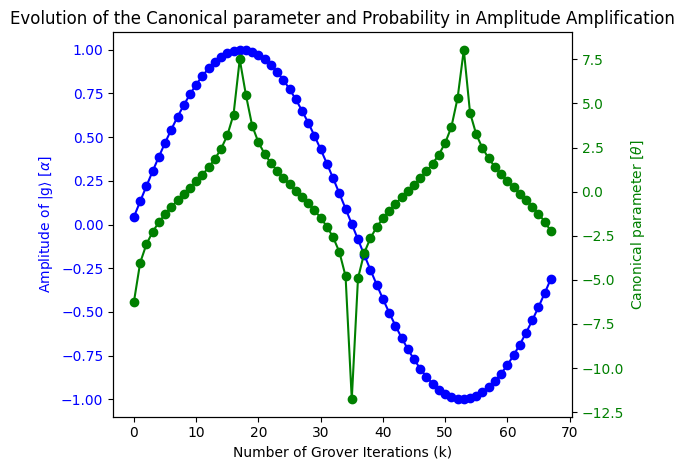

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math

N = 512  # Total states
M = 1  # Solution states
p0 = M/N # Probability of finding a good state
k = np.floor(math.pi / 4 * np.sqrt(1/p0))

# Number of Grover iterations
k_values = np.arange(0, 4*np.floor(math.pi /4 * np.sqrt(1/p0)))  # From 0 to 4 times the needed rotations 

# Initial alpha (assume M/N = 1/8 for an example)
alpha_0 = np.arcsin(np.sqrt(p0))

# Compute alpha after k iterations
alpha_k = (2 * k_values + 1) * alpha_0

# Compute amplitudes and probabilities
amplitude_w = np.sin(alpha_k)  # Amplitude of solution state |w⟩
probability_w = amplitude_w**2  # Probability of measuring |w⟩

# Initial theta value -- canonical parameter for the exponential family
theta_0 = math.log(((1-p0)*p0)/((1-p0)*p0))

# Compute theta after k iterations from the probabilities
theta_k = []
for i in range(0, len(k_values)):
    theta_k.append(math.log((probability_w[i])/(1-probability_w[i])))

# Plot the rotation as a function of iterations
fig, ax1 = plt.subplots()

ax1.set_xlabel("Number of Grover Iterations (k)")
ax1.set_ylabel("Amplitude of |g⟩ [" + r"$\alpha$" + "]", color="blue")
ax1.plot(k_values, amplitude_w, "bo-", label="Amplitude (sinθ)")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Canonical parameter [" + r"${\theta}$" + "]", color="green")
ax2.plot(k_values, theta_k, "go-", label="Canonical parameter [" + r"${\theta}$" + "]")
ax2.tick_params(axis="y", labelcolor="green")

print("The rotations needed for maximum amplification: ", k)
print("The rotations presented in the picture: ", 4*k)
print("The starting probability:" + "p_0" + " =", M, "/", N)

plt.title("Evolution of the Canonical parameter and Probability in Amplitude Amplification")
fig.tight_layout()
plt.show()



In [22]:
import numpy as np
import math

# Define the range and probabilities
k = np.linspace(0, 10, 10001)
p = [0.01, 0.05, 0.1, 0.25, 0.5]

# Initialize dictionaries
mcmc = {}
rejection = {}
quantum = {}

# Populate dictionaries
for prob in p:
    mcmc[prob] = []
    rejection[prob] = []
    quantum[prob] = []
    
    for i in k:
        mcmc[prob].append(math.e ** i)       # Exponential growth
        rejection[prob].append(1 / prob)     # Constant for each p
        quantum[prob].append(i / np.sqrt(prob))  # Linear in k, scaled by 1/sqrt(p)


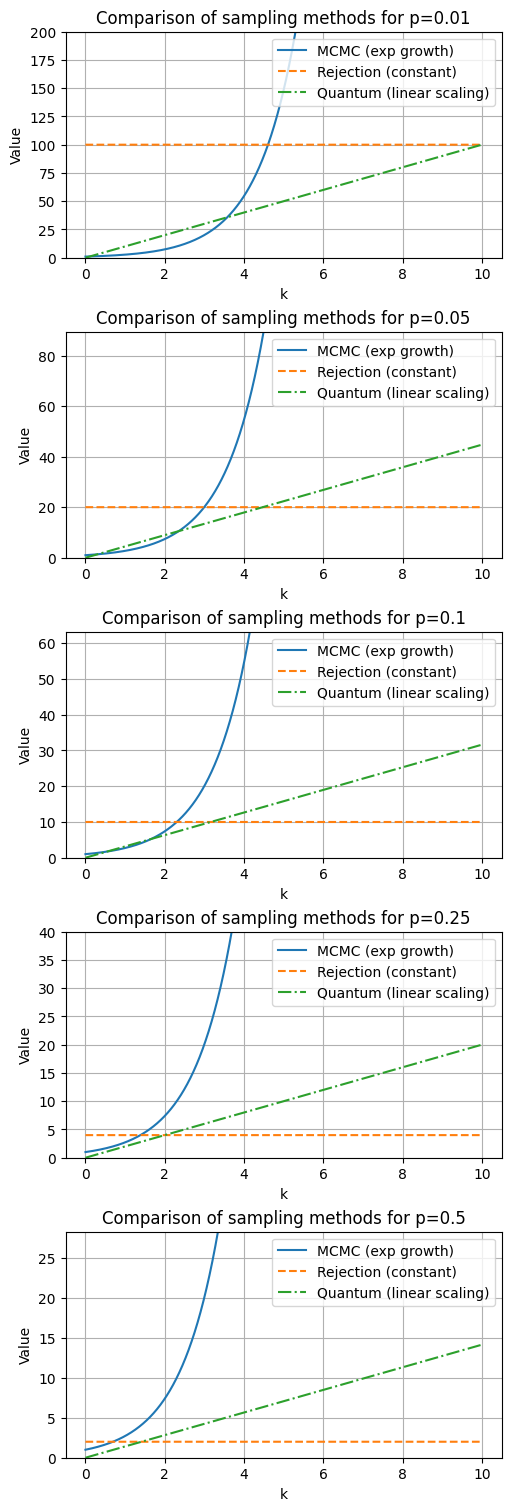

In [29]:
fig, axs = plt.subplots(len(p), 1, figsize=(5, 15), constrained_layout=True)

for idx, prob in enumerate(p):
    max_y = max(quantum[prob])

    axs[idx].plot(k, mcmc[prob], label='MCMC (exp growth)', color='tab:blue')
    axs[idx].plot(k, rejection[prob], label='Rejection (constant)', color='tab:orange', linestyle='--')
    axs[idx].plot(k, quantum[prob], label='Quantum (linear scaling)', color='tab:green', linestyle='-.')
    axs[idx].set_ylim(bottom = 0, top=2 * max_y)
    axs[idx].set_title(f'Comparison of sampling methods for p={prob}')
    axs[idx].set_xlabel('k')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()
    axs[idx].grid(True)

plt.show()

# Transpilaion

In [40]:
from qiskit import QuantumCircuit, transpile
from qiskit_ionq import IonQProvider
from qiskit_ibm_runtime import QiskitRuntimeService

#api_key="hfXrOvg4UuaBAn2IXwyoPn25H7aO8Kmi" for TRAPPEDION
#api_key="DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR" for SUPERCONDUCTING

#QiskitRuntimeService.save_account(channel="ibm_quantum", token="DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR", overwrite=True)
#service = QiskitRuntimeService(channel="ibm_quantum", token="DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR")


# Initialize the provider (requires IonQ API key)
provider = IonQProvider()

# Choose the trapped ion backend
backend1 = provider.get_backend("ionq_qpu", gateset="native")  # or "ionq_simulator" for simulation

# Transpile
transpiled_circuit_trapped = transpile(qc, backend=backend1)
gate_counts_trapped = transpiled_circuit_trapped.count_ops()
gate_counts_trapped

OrderedDict([('gpi2', 186), ('gpi', 41), ('ms', 26)])

In [42]:
service = QiskitRuntimeService()
backend2 = service.backend("ibm_brisbane")
transpiled_circuit_superc = transpile(qc, backend=backend2)
gate_counts_superc = transpiled_circuit_superc.count_ops()
gate_counts_superc

OrderedDict([('rz', 140), ('sx', 94), ('ecr', 36), ('x', 8)])

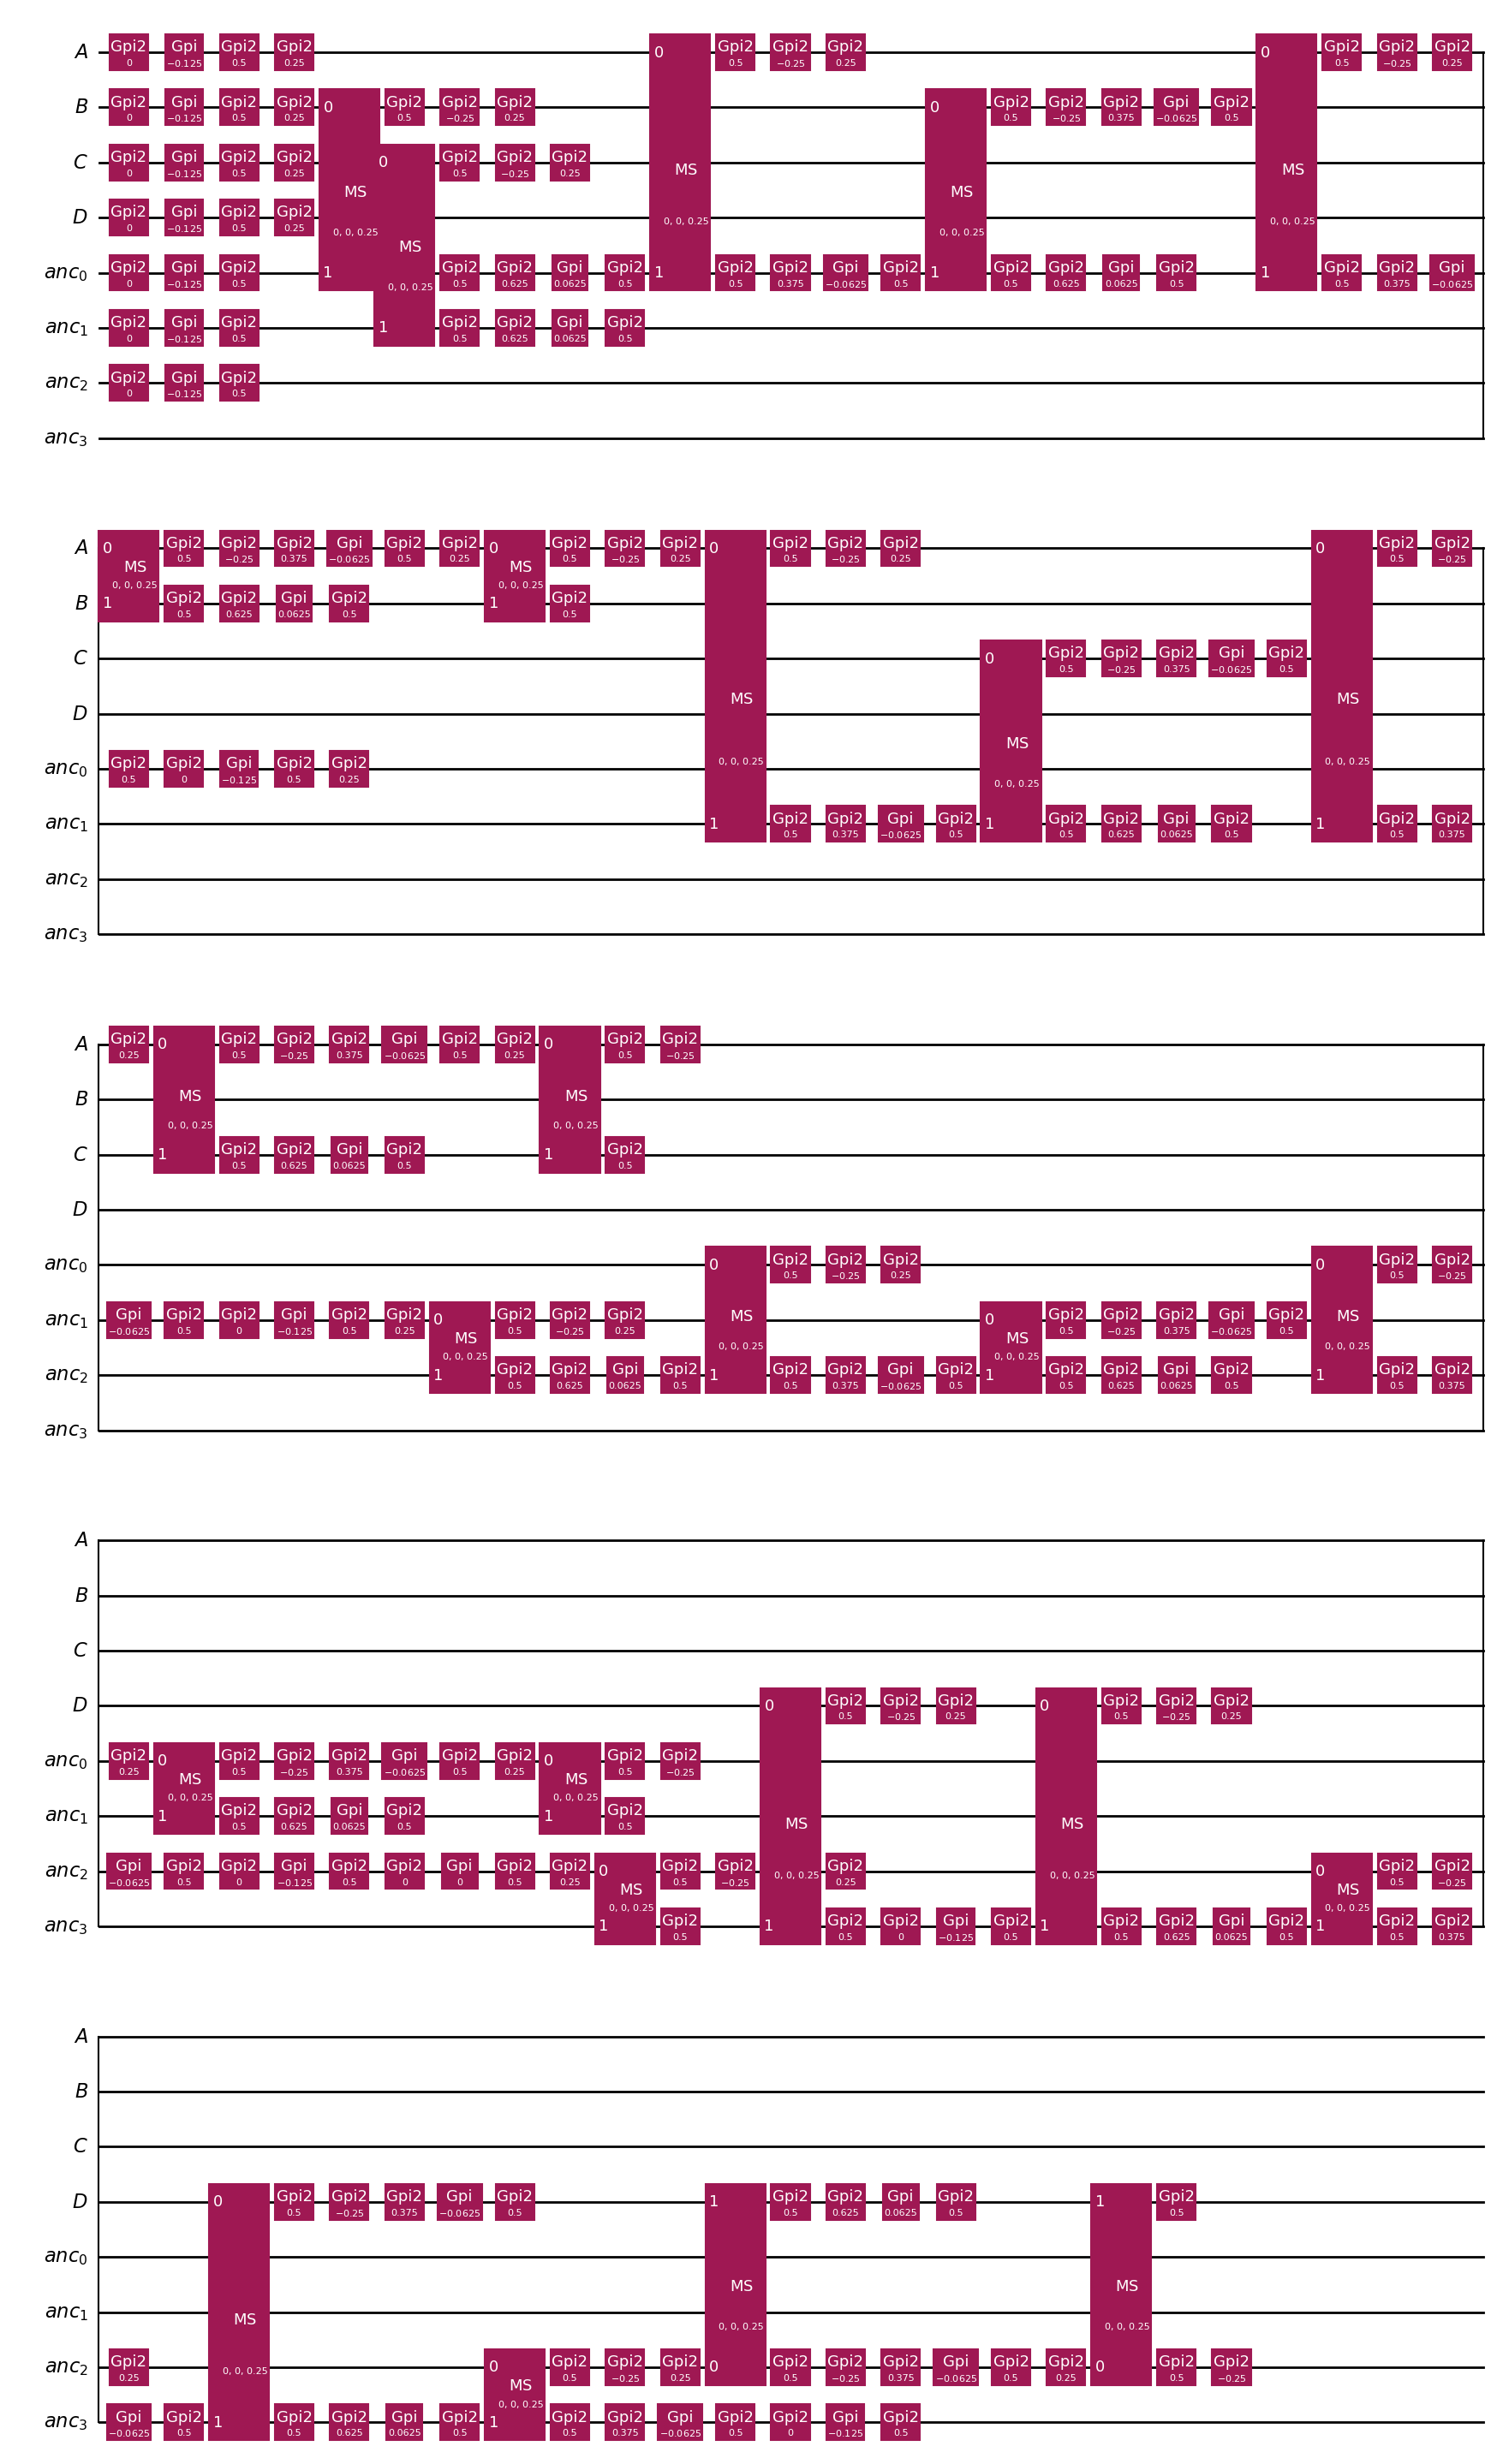

In [30]:
transpiled_circuit_trapped.draw('mpl')

In [39]:
transpiled_circuit_superc.draw()

global phase: π/4
                                                                       »
    ancilla_0 -> 0 ────────────────────────────────────────────────────»
                                                                       »
    ancilla_1 -> 1 ────────────────────────────────────────────────────»
                                                                       »
    ancilla_2 -> 2 ────────────────────────────────────────────────────»
                   ┌─────────┐    ┌────┐  ┌───────────────┐   ┌────┐   »
          B_0 -> 3 ┤ Rz(π/2) ├────┤ √X ├──┤ Rz(-0.027363) ├───┤ √X ├───»
                   └─────────┘    └────┘  └───────────────┘   └────┘   »
        anc_0 -> 4 ────────────────────────────────────────────────────»
                   ┌──────────┐   ┌────┐     ┌──────────┐              »
        anc_2 -> 5 ┤ Rz(-π/2) ├───┤ √X ├─────┤ Rz(-π/2) ├──────────────»
                   ├──────────┤   ├────┤   ┌─┴──────────┴┐             »
        anc_3 -> 6 ┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(0.69282) ├─────────────»
                   ├──────────┤   ├────┤   ├─────────────┴┐   ┌────┐   »
          D_0 -> 7 ┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-0.16655) ├───┤ √X ├───»
                   └──────────┘   └────┘   └──────────────┘   └────┘   »
    ancilla_3 -> 8 ────────────────────────────────────────────────────»
                                                                       »
    ancilla_4 -> 9 ────────────────────────────────────────────────────»
                                                                       »
   ancilla_5 -> 10 ────────────────────────────────────────────────────»
                                                                       »
   ancilla_6 -> 11 ────────────────────────────────────────────────────»
                                                                       »
   ancilla_7 -> 12 ────────────────────────────────────────────────────»
                                                                       »
   ancilla_8 -> 13 ────────────────────────────────────────────────────»
                                                                       »
   ancilla_9 -> 14 ────────────────────────────────────────────────────»
                   ┌──────────┐   ┌────┐   ┌──────────────┐   ┌────┐   »
         A_0 -> 15 ┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-0.32197) ├───┤ √X ├───»
                   └──────────┘   └────┘   └──────────────┘   └────┘   »
  ancilla_10 -> 16 ────────────────────────────────────────────────────»
                                                                       »
  ancilla_11 -> 17 ────────────────────────────────────────────────────»
                                                                       »
  ancilla_12 -> 18 ────────────────────────────────────────────────────»
                                                                       »
  ancilla_13 -> 19 ────────────────────────────────────────────────────»
                                                                       »
  ancilla_14 -> 20 ────────────────────────────────────────────────────»
                   ┌─────────┐    ┌────┐       ┌──────┐       ┌───┐    »
         C_0 -> 21 ┤ Rz(π/2) ├────┤ √X ├───────┤0     ├───────┤ X ├────»
                   └──┬────┬─┘ ┌──┴────┴─┐     │  Ecr │    ┌──┴───┴───┐»
       anc_1 -> 22 ───┤ √X ├───┤ Rz(π/2) ├─────┤1     ├────┤ Rz(3π/4) ├»
                      └────┘   └─────────┘     └──────┘    └──────────┘»
  ancilla_15 -> 23 ────────────────────────────────────────────────────»
                                                                       »
  ancilla_16 -> 24 ────────────────────────────────────────────────────»
                                                                       »
  ancilla_17 -> 25 ────────────────────────────────────────────────────»
                                                                       »
  ancilla_18 -> 26 ────────────────────────────────────────────────────»
                                        

In [36]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
native_gates = backend.configuration().basis_gates

# Transpile using the native gate set
transpiled = transpile(qc, backend=backend, basis_gates=native_gates)


In [34]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token="DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR")
print(service.instances())


IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

CloudResourceNameResolutionError: 'Failed to resolve CRN value for the provided service name None.'

In [20]:
import os
os.environ["QISKIT_IBM_TOKEN"] = "DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR"


In [21]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_quantum", token="DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR", overwrite=True)

In [25]:
QiskitRuntimeService.save_account(
    token="DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR",
    channel = 'ibm_quantum',
    #region="eu-de",  # or "eu-de" depending on your account
    # plans_preference=['Open', 'Premium'],  # optional, prioritize plan types
    set_as_default=True
)

AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'

In [35]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
print(service.backends(simulator=False, operational=True, min_num_qubits=5))

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]
